In [1]:
using Distributions, Plots, CSV, SpectraFit, StatsBase, Optim, DataFrames

In [2]:
cos2α_dist = Uniform(-1, 1)
sinβ_dist = Uniform(-1, 1);

In [3]:
struct chemical_shift_params
    σᵢₛₒ::Normal
    Δσ::Normal
    ησ::Truncated{Normal{Float64},Continuous,Float64}
end

In [4]:
function get_ν(α::Float64, β::Float64, σᵢₛₒ::Normal, Δσ::Normal, ησ::Truncated{Normal{Float64},Continuous,Float64}) 
    Δσ_sample = rand(Δσ)
    σᵢₛₒ_sample = rand(σᵢₛₒ)
    ησ_sample = rand(ησ)
    σᵢₛₒ_sample - (Δσ_sample / 3) * (3 * (1 - β^2) - 1 - ησ_sample * β^2 * α);
end;

In [5]:
function get_powder_pattern(params::chemical_shift_params, N::Int64)
    α = rand(cos2α_dist, N)
    β = rand(sinβ_dist, N)
    return get_ν.(α, β, params.σᵢₛₒ, params.Δσ, params.ησ)
end;

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


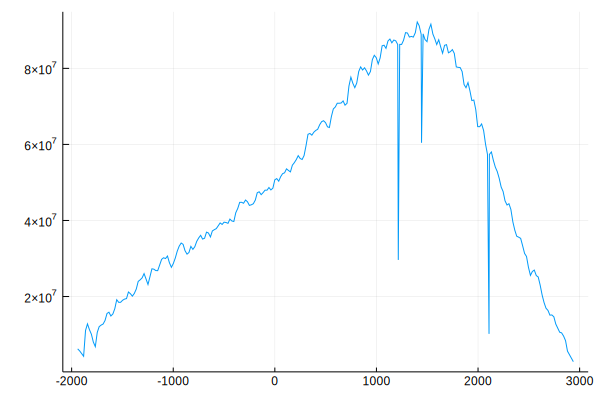

In [6]:
experimental_data = get_experimental(get_data("80 envelope.csv"), delim = ",", reverse_data = true)
exp_ecdf = SpectraFit.get_experimental_ecdf(experimental_data)
plot(experimental_data[:, 1], experimental_data[:, 2], legend = false)

In [7]:
function ols_cdf(parameters::ChemicalShift, exp::Array{Float64, 2}, exp_ecdf::Array{Float64, 1})
    th_ecdf = ecdf(SpectraFit.estimate_powder_pattern(parameters, 1_000_000)).(exp[:, 1])
    return sum((exp_ecdf .- th_ecdf) .^ 2)
end

ols_cdf (generic function with 1 method)

In [8]:
result = optimize(
    x -> ols_cdf(
        ChemicalShift([Normal(x[1], x[2] ^ 2)], [Normal(x[3], x[4] ^ 2)], 
            [truncated(Normal(x[5] ^ 2, x[6] ^ 2), 0, 1)], [1.0]),
        experimental_data,
        exp_ecdf,
    ),
    [-166.9133739998846, sqrt(535.721301891228), -3107.470762342848, sqrt(57.366984456315755), 
        sqrt(0.055155464413741175), sqrt(0.1)],
    Optim.Options(iterations = 1_000),
)

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [-2.67e+02, 2.31e+01, -3.17e+03,  ...]
    Minimum:   2.268612e-03

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [-1.67e+02, 2.31e+01, -3.11e+03,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   545  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2709


In [9]:
function results_table(minimizer)
    df = DataFrame(["σᵢₛₒ" minimizer[1] minimizer[2]^2
                    "Δσ" minimizer[3] minimizer[4]^2
                    "ησ"  minimizer[5]^2  minimizer[6]^2])
    colnames = ["Parameter","Mean","St. Dev."]
    rename!(df, Symbol.(colnames))
    return df
end
results_table(result.minimizer)

,Parameter,Mean,St. Dev.
,Any,Any,Any
1,σᵢₛₒ,-267.255,534.534
2,Δσ,-3170.25,79.0746
3,ησ,0.0661956,0.0621017


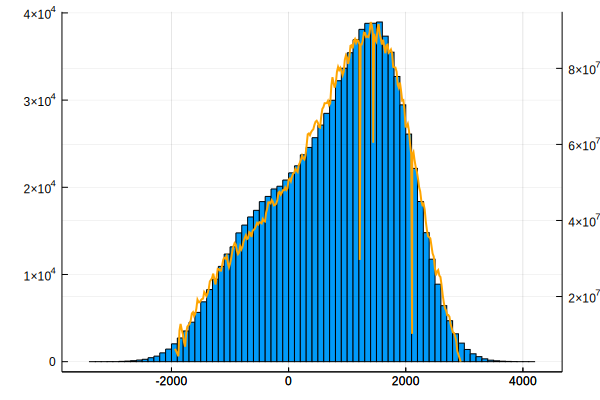

In [10]:
histogram(get_powder_pattern(chemical_shift_params(Normal(result.minimizer[1], result.minimizer[2] ^ 2), 
            Normal(result.minimizer[3], result.minimizer[4] ^ 2), 
            truncated(Normal(result.minimizer[5] ^ 2, result.minimizer[6] ^ 2), 0, 1)), 
                1_000_000), legend = false, bins = 100)
plot!(twinx(), experimental_data[:, 1], experimental_data[:, 2], legend = false, color = :orange, width = 2)